In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Mounted at /content/gdrive


In [ ]:
df=pd.read_csv(r'/content/gdrive/My Drive/Amazon AB/full datasets/DeRev_Dataset.csv')
df.head()

,Unnamed: 0,Title,text,Label
0,0,A Dubious Game-Another Kubicki Masterpiece,Gerald Kubicki has done it again. A Dubious P...,Fake
1,1,Great Read! Highly Recommended!,"Circle of Lies, by Douglas Alan is a fast pace...",Fake
2,2,Couldn't put it down!,"""Coin for a Killer"" is a fast-paced, page turn...",Fake
3,3,A moving experience!,"""Destined to Live, Despite Me: Biblical Truths...",Fake
4,4,Truly wonderful!,This book is a true testament to the resolve o...,Fake


In [ ]:
df['review'] = df['Title'] + ' ' + df['text']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  236 non-null    int64 
 1   Title       236 non-null    object
 2   text        236 non-null    object
 3   Label       236 non-null    object
 4   review      236 non-null    object
dtypes: int64(1), object(4)
memory usage: 9.3+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of fake v genuine reviews')

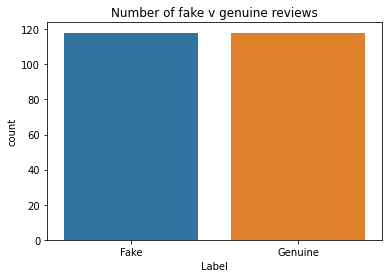

In [ ]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of fake v genuine reviews')

In [ ]:
X = df.review
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [ ]:
#from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#cv=CountVectorizer(ngram_range=(1,2))
#vec = TfidfVectorizer()
#X=vec.fit_transform(X)

In [ ]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [ ]:
#X_train = X_train.toarray()
#X_test = X_test.toarray()


In [ ]:
max_words = 1150
max_len = 225
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
len(X.array)

236

In [ ]:
Y_train.shape

(188, 1)

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 225)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 225, 50)           57500     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [ ]:
model.fit(sequences_matrix,Y_train,batch_size=4,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_accuracy',min_delta=0.000001)])

Epoch 1/10
38/38 [==============================] - 5s 61ms/step - loss: 0.6945 - accuracy: 0.5062 - val_loss: 0.6944 - val_accuracy: 0.4211
Epoch 2/10
38/38 [==============================] - 2s 47ms/step - loss: 0.6536 - accuracy: 0.6935 - val_loss: 0.5589 - val_accuracy: 0.7105
Epoch 3/10
38/38 [==============================] - 2s 47ms/step - loss: 0.3833 - accuracy: 0.9081 - val_loss: 0.3239 - val_accuracy: 0.9211
Epoch 4/10
38/38 [==============================] - 2s 47ms/step - loss: 0.1249 - accuracy: 0.9776 - val_loss: 0.2776 - val_accuracy: 0.9211


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
y_pred = model.predict(test_sequences_matrix)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

2/2 [==============================] - 0s 21ms/step - loss: 0.3645 - accuracy: 0.8333


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.365
  Accuracy: 0.833


In [ ]:
from sklearn.metrics import classification_report
target_names = ['fake', 'genuine']
print("\t\t   LSTM ")
print(classification_report(Y_test, y_pred, target_names=target_names))

		   LSTM 
              precision    recall  f1-score   support

        fake       0.85      0.85      0.85        27
     genuine       0.81      0.81      0.81        21

    accuracy                           0.83        48
   macro avg       0.83      0.83      0.83        48
weighted avg       0.83      0.83      0.83        48



In [ ]:
from sklearn.metrics import f1_score
f1_score(Y_test, y_pred, average='macro')

0.8306878306878307

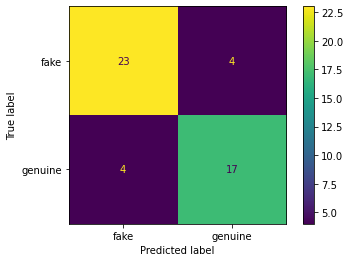

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, y_pred)#, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=['fake','genuine'])
cmd.plot()

In [ ]:
y_pred = np.round(y_pred)
y_pred

array([[0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.]], dtype=float32)